## Import

In [1]:
import pandas
import numpy as np
import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

import cv2
import os
from nltk import wordpunct_tokenize
import re
from tqdm import tqdm

In [2]:
# You need extract file ml1m.zip to folder ml1m before run code

users = pandas.read_csv('content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pandas.read_csv('content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pandas.read_csv('content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pandas.read_csv('content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

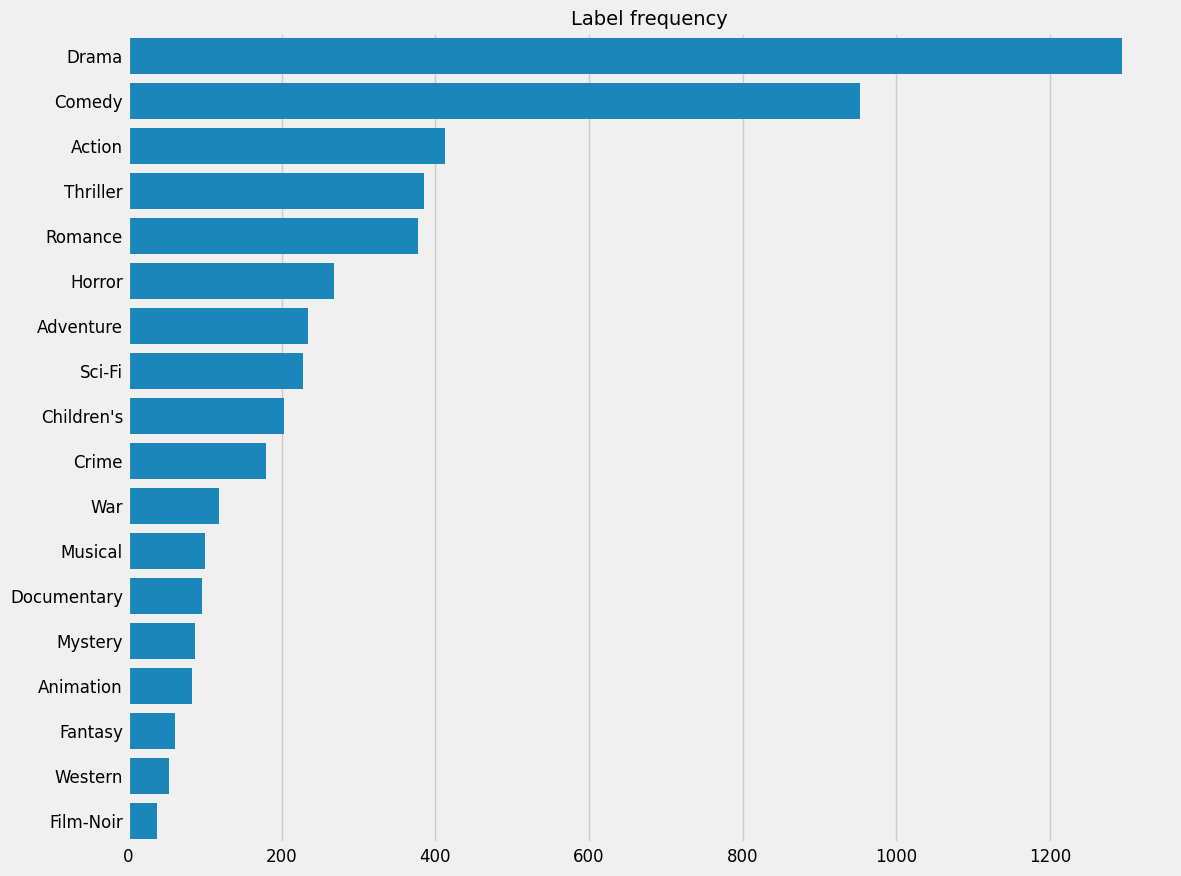

In [3]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

label_freq =  movies_train['genre'].explode().value_counts().sort_values(ascending=False)
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Dataset + Dataloader

### Rating

In [4]:
# Kết hợp vs users
ratings = pandas.merge(ratings, users, on='userid', how='outer')
ratings = ratings.sort_values(by='movieid')

# Lấy những cột cần thiết
new_column = ['movieid', 'rating', 'gender', 'age', 'occupation']
ratings = ratings[new_column]

In [5]:
# Sử dụng groupby và agg để kết hợp các hàng có dữ liệu giống nhau
ratings = (
    ratings.groupby(["movieid"], observed=False).agg(lambda x: list(x)).reset_index()
)

In [6]:
for i in range(0, len(ratings)):
    rate = ratings["rating"][i]
    new_rate = np.zeros((1, 5))

    gender = ratings["gender"][i]
    gender_list = ["M", "F"]
    new_gender = np.zeros((2, 5))

    age = ratings["age"][i]
    age_list = [1, 18, 25, 35, 45, 50, 56]
    new_age = np.zeros((7, 5))

    occupation = ratings["occupation"][i]
    new_occupation = np.zeros((21, 5))

    for j in range(0, len(rate)):
        new_rate[0][rate[j] - 1] += 1
        new_gender[gender_list.index(gender[j])][rate[j] - 1] += 1
        new_age[age_list.index(age[j])][rate[j] - 1] += 1
        new_occupation[occupation[j]][rate[j] - 1] += 1

    ratings.at[i, "rating"] = (
        new_rate.tolist()
        + new_gender.tolist()
        + new_age.tolist()
        + new_occupation.tolist()
    )

In [7]:
new_column = ['movieid', 'rating']
ratings = ratings[new_column]
ratings

,movieid,rating
0,1,"[[16.0, 61.0, 345.0, 835.0, 820.0], [10.0, 45...."
1,2,"[[42.0, 108.0, 266.0, 237.0, 48.0], [30.0, 86...."
2,3,"[[44.0, 95.0, 191.0, 105.0, 43.0], [33.0, 68.0..."
3,4,"[[21.0, 47.0, 65.0, 31.0, 6.0], [17.0, 26.0, 2..."
4,5,"[[28.0, 54.0, 118.0, 80.0, 16.0], [19.0, 44.0,..."
...,...,...
3701,3948,"[[35.0, 75.0, 222.0, 367.0, 163.0], [20.0, 57...."
3702,3949,"[[9.0, 15.0, 40.0, 108.0, 132.0], [4.0, 9.0, 2..."
3703,3950,"[[2.0, 5.0, 14.0, 21.0, 12.0], [2.0, 5.0, 9.0,..."
3704,3951,"[[1.0, 3.0, 9.0, 13.0, 14.0], [1.0, 1.0, 3.0, ..."


### Train set and test set

In [8]:
folder_img_path = "content/dataset/ml1m-images"
movies_train["id"] = movies_train.index
movies_train.reset_index(inplace=True)
movies_train["img_path"] = movies_train.apply(
    lambda row: os.path.join(folder_img_path, f"{row.id}.jpg"), axis=1
)
movies_train = pandas.merge(movies_train, ratings, on="movieid", how="left")
xx = [[0.0] * 5 for _ in range(31)]
movies_train['rating'] = movies_train['rating'].apply(lambda x: x if isinstance(x, list) else xx)
movies_train

,movieid,title,genre,id,img_path,rating
0,1650,Washington Square (1997),[Drama],1650,content/dataset/ml1m-images\1650.jpg,"[[3.0, 5.0, 18.0, 20.0, 4.0], [2.0, 3.0, 10.0,..."
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185,content/dataset/ml1m-images\185.jpg,"[[45.0, 165.0, 203.0, 131.0, 25.0], [36.0, 142..."
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377,content/dataset/ml1m-images\1377.jpg,"[[81.0, 207.0, 443.0, 255.0, 45.0], [58.0, 173..."
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204,content/dataset/ml1m-images\3204.jpg,"[[2.0, 13.0, 69.0, 88.0, 32.0], [2.0, 13.0, 56..."
4,1901,Dear Jesse (1997),[Documentary],1901,content/dataset/ml1m-images\1901.jpg,"[[0.0, 1.0, 0.0, 2.0, 2.0], [0.0, 1.0, 0.0, 2...."
...,...,...,...,...,...,...
3101,2539,Analyze This (1999),[Comedy],2539,content/dataset/ml1m-images\2539.jpg,"[[17.0, 79.0, 226.0, 232.0, 62.0], [10.0, 55.0..."
3102,3038,"Face in the Crowd, A (1957)",[Drama],3038,content/dataset/ml1m-images\3038.jpg,"[[1.0, 1.0, 10.0, 32.0, 30.0], [0.0, 1.0, 7.0,..."
3103,1832,Heaven's Burning (1997),"[Action, Drama]",1832,content/dataset/ml1m-images\1832.jpg,"[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0...."
3104,657,Yankee Zulu (1994),"[Comedy, Drama]",657,content/dataset/ml1m-images\657.jpg,"[[0.0, 0.0, 2.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0...."


In [9]:
folder_img_path = "content/dataset/ml1m-images"
movies_test["id"] = movies_test.index
movies_test.reset_index(inplace=True)
movies_test["img_path"] = movies_test.apply(
    lambda row: os.path.join(folder_img_path, f"{row.id}.jpg"), axis=1
)
movies_test = pandas.merge(movies_test, ratings, on="movieid", how="left")
movies_test['rating'] = movies_test['rating'].apply(lambda x: x if isinstance(x, list) else xx)
movies_test

,movieid,title,genre,id,img_path,rating
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397,content/dataset/ml1m-images\3397.jpg,"[[7.0, 23.0, 99.0, 157.0, 72.0], [6.0, 20.0, 6..."
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067,content/dataset/ml1m-images\2067.jpg,"[[6.0, 33.0, 108.0, 188.0, 229.0], [4.0, 21.0,..."
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651,content/dataset/ml1m-images\2651.jpg,"[[10.0, 10.0, 27.0, 28.0, 7.0], [10.0, 7.0, 23..."
3,2989,For Your Eyes Only (1981),[Action],2989,content/dataset/ml1m-images\2989.jpg,"[[4.0, 46.0, 160.0, 163.0, 52.0], [2.0, 34.0, ..."
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415,content/dataset/ml1m-images\3415.jpg,"[[2.0, 3.0, 2.0, 6.0, 10.0], [2.0, 1.0, 1.0, 6..."
...,...,...,...,...,...,...
772,2309,"Inheritors, The (Die Siebtelbauern) (1998)",[Drama],2309,content/dataset/ml1m-images\2309.jpg,"[[0.0, 0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0...."
773,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",2421,content/dataset/ml1m-images\2421.jpg,"[[63.0, 125.0, 201.0, 79.0, 9.0], [55.0, 97.0,..."
774,3255,"League of Their Own, A (1992)","[Comedy, Drama]",3255,content/dataset/ml1m-images\3255.jpg,"[[14.0, 74.0, 337.0, 499.0, 175.0], [10.0, 60...."
775,974,Algiers (1938),"[Drama, Romance]",974,content/dataset/ml1m-images\974.jpg,"[[0.0, 1.0, 4.0, 9.0, 2.0], [0.0, 1.0, 3.0, 4...."


In [10]:
def tokenize(text):
    text = re.sub(r"[^\w\s]", "", text)  # remove parentheses
    text = text.lower()
    tokens = wordpunct_tokenize(text)  # split words into list
    tokens = tokens[:-1]  # remove last token because it is the year which maybe is not useful
    return tokens

# list of all words in all titles
def create_vocab():
    df = movies_train.copy()
    arr_title = df["title"].tolist()
    vocab = set()
    for title in arr_title:
        tokens = tokenize(title)
        vocab.update(tokens)
    vocab = list(vocab)
    pad_token = "<PAD>"
    unk_token = "<UNK>"
    vocab.insert(0, unk_token)
    vocab.insert(0, pad_token)
    return vocab

In [11]:
MAX_LENGTH = 7

class MLDataset(Dataset):
    def __init__(self, is_train=True, augmentation_method=None, angle=20):
        if is_train:
            self.data =  movies_train
        else:
            self.data = movies_test
        self.data['title_tokens'] = [tokenize(img_tensor) for img_tensor in self.data.title]
        self.augmentation_method = augmentation_method
        self.angle = angle

        # create vocab
        vocab = create_vocab()
        pad_token = '<PAD>'
        unk_token = '<UNK>'
        self.token2idx = {token: idx for idx, token in enumerate(vocab)} # a dictionary that change from token to idx

        # Create a binary vector for each word in each title
        vectors = []
        for title_tokens in self.data.title_tokens.tolist():
            if len(title_tokens) < MAX_LENGTH:
                num_pad = MAX_LENGTH - len(title_tokens)
                for idx in range(num_pad):
                    title_tokens.append(pad_token)
            else:
                title_tokens = title_tokens[:MAX_LENGTH]

            # print("Title_token: ", title_tokens)
            title_vectors = []
            for word in title_tokens:
                if word in vocab:
                    title_vectors.append(self.token2idx[word])
                else:
                    title_vectors.append(self.token2idx[unk_token])
            vectors.append(np.array(title_vectors))
        self.data['vectors'] = vectors

        # label genre
        with open('content/dataset/genres.txt', 'r') as f:
            genre_all = f.readlines()
            genre_all = [img_tensor.replace('\n','') for img_tensor in genre_all]
        # print(genre_all)
        self.genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}


    def __getitem__(self, index):
        img_path = self.data.iloc[index].img_path
        rate_data = self.data.iloc[index].rating
        genre = self.data.iloc[index].genre

        # preprocess text
        title_vector = self.data.iloc[index].vectors
        title_tensor = torch.from_numpy(title_vector).int()

        # preprocess img
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
        else:
            img = np.random.rand(256,256,3)
        if self.augmentation_method == "rotate":
            image_center = tuple(np.array(img.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, self.angle, 1.0)
            img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        elif self.augmentation_method == "Flip horizontally":
            img = cv2.flip(img, 1)
        elif self.augmentation_method == "Brightness adjustment":
            img = cv2.convertScaleAbs(img, alpha=1.5, beta=30)
        elif self.augmentation_method == "Contrast adjustment":
            img = cv2.convertScaleAbs(img, alpha=2.0, beta=0)

        img = cv2.resize(img, (256,256))
        img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img_tensor = torch.from_numpy(img.transpose(2,0,1)).float()

        # preprocess rating
        rating_vector = np.array(rate_data)
        rating_tensor = torch.from_numpy(rating_vector).float()

        # preprocess label
        genre_vector = np.zeros(len(self.genre2idx))

        for g in genre:
            genre_vector[self.genre2idx[g]] = 1
        genre_tensor = torch.from_numpy(genre_vector).float()

        return title_tensor, img_tensor, rating_tensor, genre_tensor

    def __len__(self):
        return len(self.data)

In [12]:
train_set = MLDataset(is_train=True)
train_set_rotate = MLDataset(is_train=True, augmentation_method="rotate")
train_set_flip = MLDataset(is_train=True, augmentation_method="Flip horizontally")
train_set_brighter = MLDataset(is_train=True, augmentation_method="Brightness adjustment")
train_set_constrast = MLDataset(is_train=True, augmentation_method="Contrast adjustment")
train_set.data = pandas.concat(
    [train_set.data, train_set_rotate.data, train_set_flip.data, train_set_brighter.data, train_set_constrast.data],
    axis=0,
    ignore_index=True,
)
print(len(train_set))
test_set = MLDataset(is_train=False)
print(len(test_set))

BATCH_SIZE = 32
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

15530
777


In [13]:
for title_tensor, img_tensor, rating_tensor, genre_tensor in train_dataloader:
    print(title_tensor.shape, img_tensor.shape, rating_tensor.shape, genre_tensor.shape)
    break

for title_tensor, img_tensor, rating_tensor, genre_tensor in test_dataloader:
    print(title_tensor.shape, img_tensor.shape, rating_tensor.shape, genre_tensor.shape)
    break

torch.Size([32, 7]) torch.Size([32, 3, 256, 256]) torch.Size([32, 31, 5]) torch.Size([32, 18])
torch.Size([32, 7]) torch.Size([32, 3, 256, 256]) torch.Size([32, 31, 5]) torch.Size([32, 18])


## Model

In [14]:
with open("content/dataset/genres.txt", "r") as f:
    genre_all = f.readlines()
num_classes = len(genre_all)
num_classes

18

In [15]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights


class Model(nn.Module):
    def __init__(
        self,
        num_classes,
        len_vocab,
        model_name,
        embedding_dimension=3898,
        hidden_size=64,
    ):
        super().__init__()

        self.flatten = nn.Flatten()

        # img model
        if model_name == "resnet18":
            self.img_model = resnet18(weights=ResNet18_Weights.DEFAULT, progress=True)
        elif model_name == "resnet34":
            self.img_model = resnet34(weights=ResNet34_Weights.DEFAULT, progress=True)
        elif model_name == "resnet50":
            self.img_model = resnet50(weights=ResNet50_Weights.DEFAULT, progress=True)
        elif model_name == "resnet101":
            self.img_model = resnet101(weights=ResNet101_Weights.DEFAULT, progress=True)
        elif model_name == "densenet121":
            self.img_model = densenet121(
                weights=DenseNet121_Weights.DEFAULT, progress=True
            )
        elif model_name == "mobilenet_v2":
            self.img_model = mobilenet_v2(
                weights=MobileNet_V2_Weights.DEFAULT, progress=True
            )
        elif model_name == "mobilenet_v3":
            self.img_model = mobilenet_v3_small(
                weights=MobileNet_V3_Small_Weights.DEFAULT, progress=True
            )
        else:
            raise ValueError(f"model {model_name} not supported")

        for param in self.img_model.parameters():
            param.requires_grad = False

        if (
            model_name == "resnet18"
            or model_name == "resnet34"
            or model_name == "resnet50"
            or model_name == "resnet101"
        ):
            self.in_features = self.img_model.fc.in_features
            self.img_model.fc = torch.nn.Linear(
                self.in_features, hidden_size, bias=True
            )
        elif model_name == "densenet121":
            self.in_features = self.img_model.classifier.in_features
            self.img_model.classifier = nn.Linear(
                self.in_features, hidden_size, bias=True
            )
        elif model_name == "mobilenet_v2":
            self.in_features = self.img_model.classifier[1].in_features
            self.img_model.classifier[1] = nn.Linear(
                self.in_features, hidden_size, bias=True
            )
        elif model_name == "mobilenet_v3":
            self.in_features = self.img_model.classifier[-1].in_features
            self.img_model.classifier[-1] = nn.Linear(
                self.in_features, hidden_size, bias=True
            )

        # rating model # N, 31, 5
        self.rating_model = nn.Sequential(
            nn.Linear(31 * 5, 256, bias=True),
            nn.Linear(256, 128, bias=True),
            nn.Linear(128, hidden_size, bias=True),
        )

        # title model # N, 7
        self.embedding_layer = nn.Embedding(len_vocab, embedding_dimension)
        self.lstm = nn.LSTM(
            input_size=embedding_dimension,
            hidden_size=hidden_size,
            num_layers=3,
            batch_first=True,
        )

        self.fc3 = nn.Linear(hidden_size * 3, num_classes)

    def forward(self, title_tensor, img_tensor, rating_tensor):
        text_feat = self.embedding_layer(title_tensor)
        text_feat, (hidden, carry) = self.lstm(text_feat)
        text_feat = text_feat[:, -1]

        img_feat = self.img_model(img_tensor)

        rating_feat = self.rating_model(self.flatten(rating_tensor))

        out = self.fc3(torch.concat([text_feat, img_feat, rating_feat], dim=1))

        return out

In [16]:
vocab = create_vocab()

def get_model(model_name):
    model = Model(num_classes=num_classes, len_vocab=len(vocab), model_name=model_name)
    return model

model = get_model("resnet18")
out = model(title_tensor, img_tensor, rating_tensor)
out.shape

torch.Size([32, 18])

## Neccessary function

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### The function `model_step` to simulate each step of the model

In [18]:
def model_step(batch, model, loss_func, device):
    title_tensor, img_tensor, rating_tensor, genre_tensor = batch
    title_tensor, img_tensor, rating_tensor, genre_tensor = (
        title_tensor.to(device),
        img_tensor.to(device),
        rating_tensor.to(device),
        genre_tensor.to(device),
    )

    genre_tensor_hat = model(title_tensor, img_tensor, rating_tensor)
    loss = loss_func(genre_tensor_hat, genre_tensor)

    preds = genre_tensor_hat

    preds = torch.sigmoid(genre_tensor_hat)
    preds = torch.Tensor(preds > 0.5).float()
    return loss, preds, genre_tensor

### The function `optimizer` use the Adam to optimize the model

In [19]:
def optimizer_step(optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### The function `train_epoch` describe train for each training data

In [20]:
def train_epoch(model, train_dataloader, loss_func, optimizer, epoch, device):
    model.train()
    pbar = tqdm(train_dataloader)
    total, total_loss = 0, 0

    for batch in pbar:
        loss, preds, y = model_step(batch, model, loss_func, device)
        optimizer_step(optimizer, loss)
        total += y.numel()
        total_loss += loss.item()
        pbar.set_description(f"epoch = {epoch}, train/loss = {total_loss/total:.3f}")

    return total_loss/total

### The function `evaluation` is for the `test-loader` at each epoch

In [21]:
from torchmetrics.classification import (
    MultilabelF1Score,
    MultilabelAccuracy,
    MultilabelRecall,
    MultilabelPrecision,
)


def evaluation(model, loader, loss_func, epoch, device):
    model.eval()
    pbar = tqdm(loader)

    acc = MultilabelAccuracy(num_labels=num_classes, average="macro")
    precision = MultilabelPrecision(num_labels=num_classes, average="macro")
    recall = MultilabelRecall(num_labels=num_classes, average="macro")
    f1 = MultilabelF1Score(num_labels=num_classes, average="macro")
    f1, acc, recall, precision = (
        f1.to(device),
        acc.to(device),
        recall.to(device),
        precision.to(device),
    )
    f1_all, acc_all, recall_all, precision_all = 0, 0, 0, 0
    for batch in pbar:
        loss, preds, y = model_step(batch, model, loss_func, device)

        acc_batch = acc(preds, y)
        acc_all += acc_batch

        precision_batch = precision(preds, y)
        precision_all += precision_batch

        recall_batch = recall(preds, y)
        recall_all += recall_batch

        f1_batch = f1(preds, y)
        f1_all += f1_batch

        pbar.set_description(f"epoch = {epoch}, testing           ")

    print("Accuracy:  ", (acc_all / len(loader)).item())
    print("Precision: ", (precision_all / len(loader)).item())
    print("Recall:    ", (recall_all / len(loader)).item())
    print("F1:        ", (f1_all / len(loader)).item())

    return (
        (acc_all / len(loader)).item(),
        (precision_all / len(loader)).item(),
        (recall_all / len(loader)).item(),
        (f1_all / len(loader)).item(),
    )

### The function `train` simulate the main train

In [22]:
def train(model, train_dataloader, max_epochs=1, device="cpu", lr=1e-3):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=5e-7
    )
    model.to(device)
    los_list, f1_list, acc_list, recall_list, precision_list = [], [], [], [], []
    for epoch in range(max_epochs):
        los = train_epoch(
            model, train_dataloader, loss_func, optimizer, epoch + 1, device
        )
        acc, precision, recall, f1 = evaluation(
            model, test_dataloader, nn.CrossEntropyLoss(), epoch + 1, device
        )

        los_list.append(los)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return los_list, acc_list, precision_list, recall_list, f1_list

# Main

In [ ]:
import matplotlib.pyplot as plt

model_list = ["resnet18", "resnet34", "resnet50", "resnet101", "densenet121", "mobilenet_v2", "mobilenet_v3"]
model_name = "mobilenet_v3"
model = get_model(model_name)
max_epochs = 40
los_list, acc_list, precision_list, recall_list, f1_list = train(model, train_dataloader, max_epochs, device=device, lr=5e-6)
# evaluation(model, test_dataloader, nn.CrossEntropyLoss(), 1, device)
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model_name

'resnet101'

In [ ]:
max(f1_list)

0.24703264236450195

In [ ]:
max(precision_list)

0.18007530272006989

In [ ]:
max(recall_list)

0.5360898971557617

# Draw the plot with above results

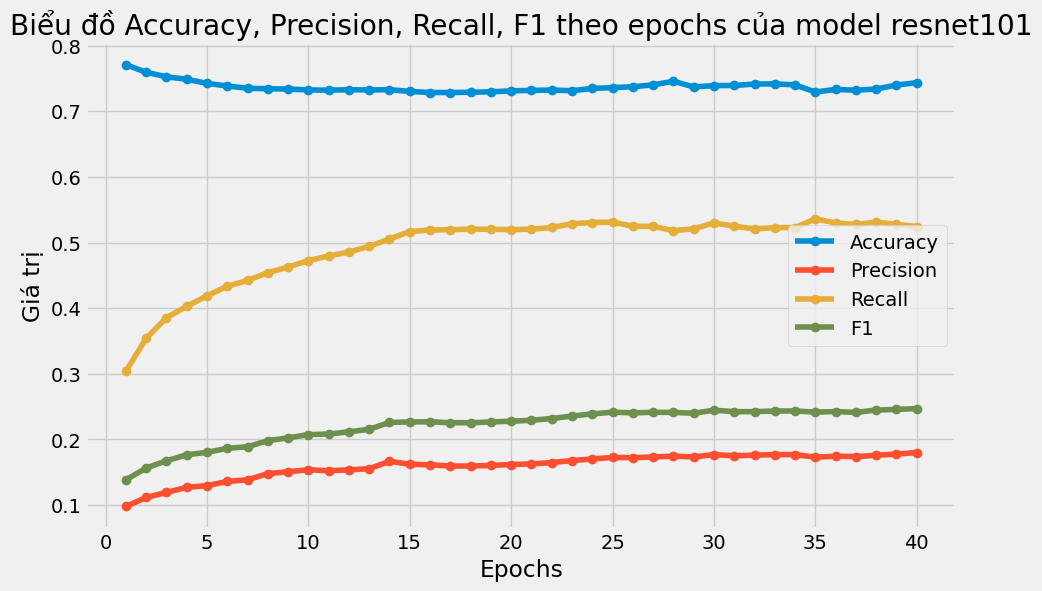

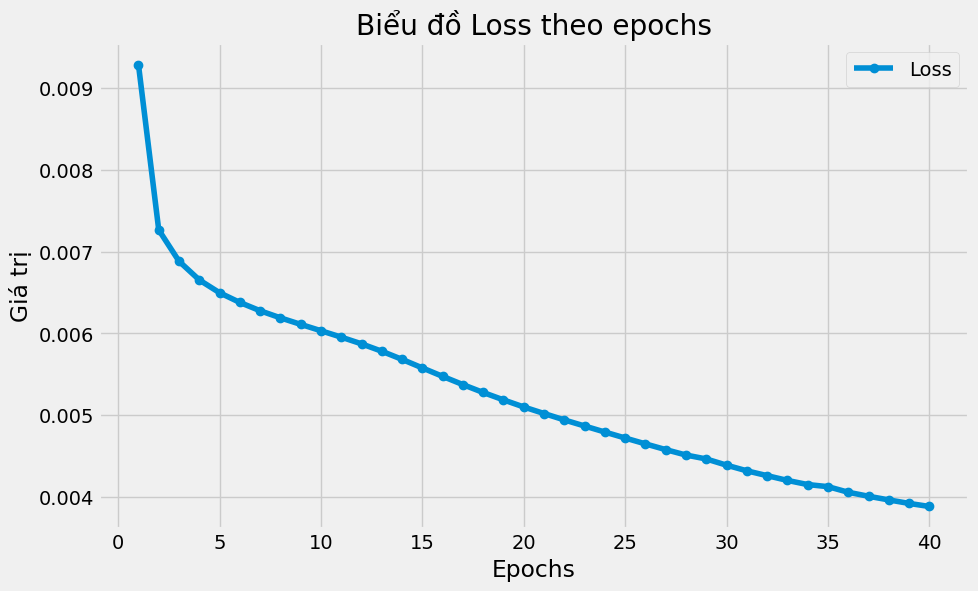

In [ ]:
epoch = np.arange(1, max_epochs + 1)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epoch, acc_list, label='Accuracy', marker='o')
plt.plot(epoch, precision_list, label='Precision', marker='o')
plt.plot(epoch, recall_list, label='Recall', marker='o')
plt.plot(epoch, f1_list, label='F1', marker='o')
plt.title("Biểu đồ Accuracy, Precision, Recall, F1 theo epochs của model " + model_name)
plt.xlabel('Epochs')
plt.ylabel('Giá trị')
plt.legend()
plt.grid(True)


plt.figure(figsize=(10, 6))
plt.plot(epoch, los_list, label='Loss', marker='o')
plt.title('Biểu đồ Loss theo epochs')
plt.xlabel('Epochs')
plt.ylabel('Giá trị')
plt.legend()
plt.grid(True)
plt.show()